In [1]:
from calibration_metrics import partition_bins
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.style.use('ggplot')

In [19]:
def plot_reliability_diagrams(fname, predictions, confidences, references):
    bins, _, bin_accs, _ = partition_bins(predictions, confidences, references)

    plt.bar(bins, bins, width=0.1, alpha=0.3, edgecolor='black', hatch='/')
    plt.bar(bins, bin_accs, width=0.1, alpha=0.7, edgecolor='black')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)
    plt.ylim([0, 1.05])
    plt.xlim([0, 1.05])
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(f"figures/{fname}")
    
def load_outputs(path):
    predictions = torch.load(f"{path}/predictions.pt")
    confidences = torch.load(f"{path}/confidences.pt")
    references = torch.load(f"{path}/references.pt")
    
    return predictions, confidences, references

def confidences_histogram(confidences):
    plt.hist(confidences.tolist(), bins=100, range=(0,1))
    plt.show()

# Reliability Diagram
## CIFAR-10
### Uncalibrated

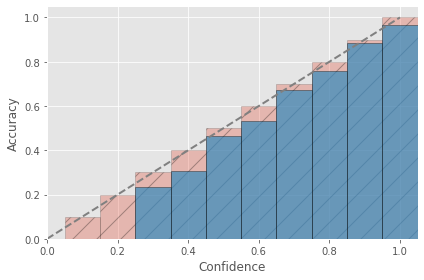

In [20]:
predictions, confidences, references = load_outputs("outputs/resnet_cifar-10_0.0229")

plot_reliability_diagrams("CIFAR-uncalibrated", predictions, confidences, references)

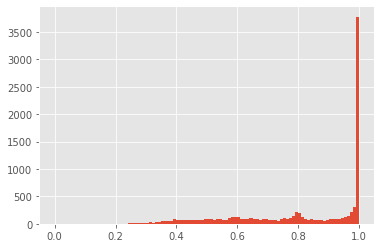

In [21]:
confidences_histogram(confidences)

### Platt

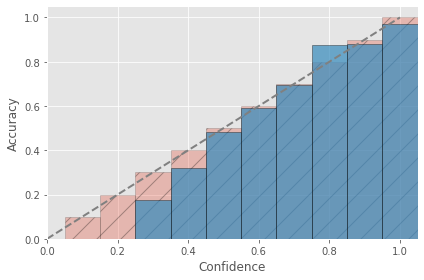

In [22]:
predictions, confidences, references = load_outputs("outputs/resnet-platt_cifar-10_0.0400")
plot_reliability_diagrams("CIFAR-Platt", predictions, confidences, references)

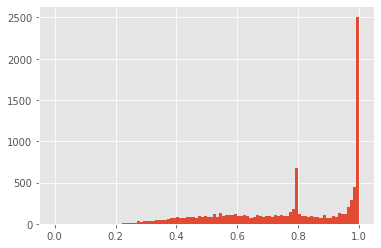

In [23]:
confidences_histogram(confidences)

### Temperature

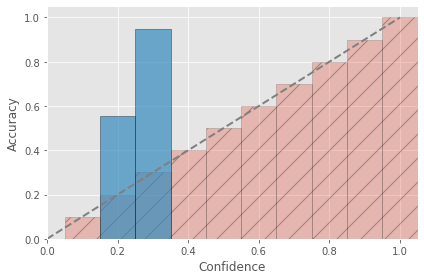

In [28]:
predictions, confidences, references = load_outputs("outputs/resnet-temp_cifar-10_0.5977")
plot_reliability_diagrams("CIFAR-Temp", predictions, confidences, references)

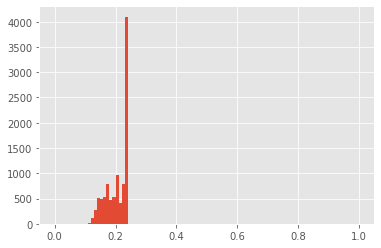

In [29]:
confidences_histogram(confidences)

## SVHN
### Uncalibrated

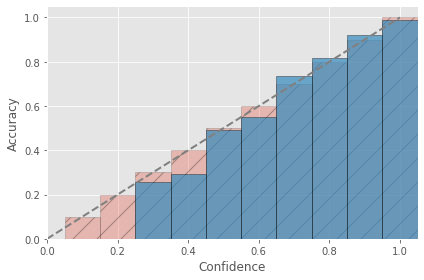

In [31]:
predictions, confidences, references = load_outputs("outputs/resnet_SVHN_0.0126")
plot_reliability_diagrams("SVHN-uncalibrated", predictions, confidences, references)

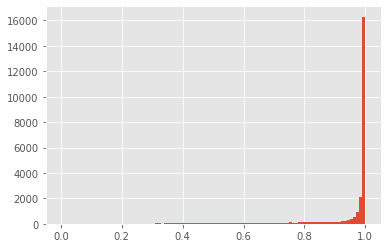

In [34]:
confidences_histogram(confidences)

### Platt

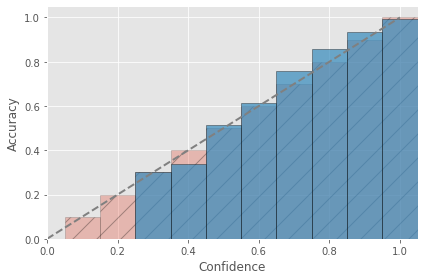

In [32]:
predictions, confidences, references = load_outputs("outputs/resnet-platt_SVHN_0.0164")
plot_reliability_diagrams("CIFAR-Platt", predictions, confidences, references)

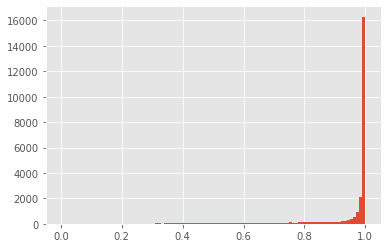

In [33]:
confidences_histogram(confidences)

### Temperature

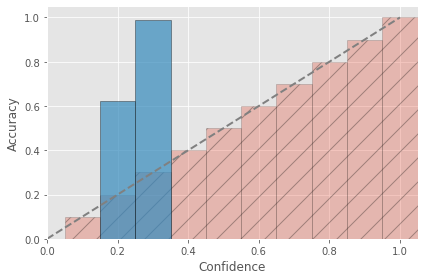

In [35]:
predictions, confidences, references = load_outputs("outputs/resnet-temp_SVHN_0.7238")
plot_reliability_diagrams("CIFAR-Platt", predictions, confidences, references)

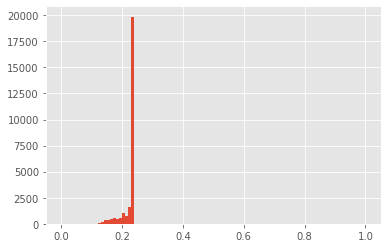

In [36]:
confidences_histogram(confidences)

# Regression

In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from regressor import MLP, QuantileMLP
import glob
%matplotlib inline
plt.style.use('ggplot')

model_dir = "/mnt/e/models/iso_models"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [141]:
def predict(model, inputs, device):
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        inputs = inputs.to(device)
        logits = model(inputs)
    
    return logits.detach()

def ensemble_predict(model_paths, model, inputs, device):
    logits = []
    print(f"Loading model from {model_paths}")
    for path in glob.iglob(model_paths):
        model.load_state_dict(torch.load(path, map_location=device))
        
        outputs = predict(model, inputs, device)
        
        logits.append(outputs.unsqueeze(0))
        
    logits = torch.cat(logits, dim=0) # no_model, no_inputs, 1
    mean_logits = logits.mean(dim=0)
    std_logits = logits.std(dim=0) * 2
    
    mean_logits = mean_logits.detach().cpu().numpy()
    std_logits = std_logits.detach().cpu().numpy()
    if mean_logits.shape[-1] == 1:
        mean_logits = mean_logits.reshape(-1)
        std_logits = std_logits.reshape(-1)
    return mean_logits, std_logits

def correct_coverage(references, lower, upper):
    less_than_upper = references <= upper
    ref_upper = references[less_than_upper]
    sub_lower = lower[less_than_upper]
    in_range = ref_upper[ref_upper >= sub_lower]
    return len(in_range)/len(references)

def plot_solar_regression(train_data, test_data, X, y, lower, upper):
    plt.scatter(train_data[:,0], train_data[:,1], c='b', label='train')
    plt.scatter(test_data[:,0], test_data[:,1], c='r', label='test')
    plt.plot(X, y, c='g', label='median')
    plt.fill_between(X, lower, upper, color="orange", label='interval', alpha=0.5)
    plt.xlim(-230, 230)
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()
    
def project_score_function(references, lower, upper):
    # project distance from y onto uncertainties
    values = np.vstack((lower - references, references - upper))
    return np.max(values, axis=0)

def conformal_calibration(references, lower, upper, quantile=0.95):
    scores = project_score_function(references, lower, upper)
    return np.quantile(scores, quantile)


## Solar

In [142]:
train_data = np.load("/mnt/e/data/solar/solar_data_train.npy")
val_data = np.load("/mnt/e/data/solar/solar_data_val.npy")
test_data = np.load("/mnt/e/data/solar/solar_data_test.npy")

In [143]:
model = MLP(input_dim=1, output_dim=1, num_units=8, drop_prob=0.01)
print(model)

solar_model_paths = os.path.join(model_dir, "mlp", f"mlp_solar_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_y, line_error = ensemble_predict(solar_model_paths, model, line_X, device)

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_y.shape, line_error.shape

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


((4600,), (4600,), (4600,))

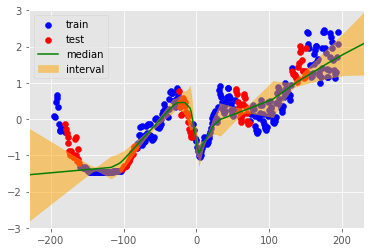

In [144]:
line_upper = line_y + line_error
line_lower = line_y - line_error
plot_train = np.concatenate((train_data, val_data))

plot_solar_regression(plot_train, test_data, line_X, line_y, line_lower, line_upper)

### Correct coverage

In [145]:
test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_preds, test_errors = ensemble_predict(solar_model_paths, model, test_X, device)
test_lower = test_preds - test_errors
test_upper = test_preds + test_errors
coverage = correct_coverage(test_data[:,1], test_lower, test_upper)
coverage # expected coverage: 0.95

Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


0.4

### Conformal calibration

In [146]:
val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_preds, val_errors = ensemble_predict(solar_model_paths, model, val_X, device)

val_lower = val_preds - val_errors
val_upper = val_preds + val_errors
q_score = conformal_calibration(val_data[:,1], val_lower, val_upper, 0.95)
q_score

Loading model from /mnt/e/models/iso_models/mlp/mlp_solar_*.pt


0.48288698047399514

In [147]:
correct_coverage(test_data[:,1], test_lower-q_score, test_upper+q_score) # expected coverage: 0.95

0.91

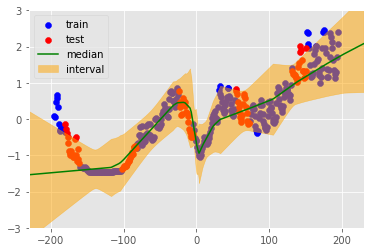

In [148]:
plot_solar_regression(plot_train, test_data, line_X, line_y, line_lower-q_score, line_upper+q_score)

## UCI

In [149]:
def UCI_calibration_error(dataset, val_data, test_data, device):
    val_X = val_data[:, :-1]
    val_y = val_data[:, -1]
    test_X = test_data[:, :-1]
    test_y = test_data[:, -1]
    print(test_X.shape)

    model_paths = os.path.join(model_dir, "mlp", f"mlp_{dataset}_*.pt")
    model = MLP(input_dim=test_X.shape[1], output_dim=1, num_units=10, drop_prob=0.01)
    print(model)

    print("### Before calibration ###")
    test_preds, test_errors = ensemble_predict(model_paths, model, torch.from_numpy(test_X).float(), device)
    lower = test_preds - test_errors
    upper = test_preds + test_errors
    coverage = correct_coverage(test_y, lower, upper)
    print(f"Coverage: {coverage}")
    print()
    
    print("### Conformal calibrating ###")
    val_preds, val_errors = ensemble_predict(model_paths, model, torch.from_numpy(val_X).float(), device)
    q_score = conformal_calibration(val_y, val_preds-val_errors, val_preds+val_errors, 0.95)
    print(f"Q-score: {q_score}")
    coverage = correct_coverage(test_y, lower-q_score, upper+q_score)
    print(f"Coverage: {coverage}")

    

### Housing

In [150]:
val_data = np.load("/mnt/e/data/house/val.npy")
test_data = np.load("/mnt/e/data/house/test.npy")
UCI_calibration_error("house", val_data, test_data, device)

(51, 12)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_house_*.pt
Coverage: 0.5294117647058824

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_house_*.pt
Q-score: 0.24103754496796215
Coverage: 0.8823529411764706


### Concrete

In [151]:
val_data = np.load("/mnt/e/data/concrete/val.npy")
test_data = np.load("/mnt/e/data/concrete/test.npy")
UCI_calibration_error("concrete", val_data, test_data, device)

(103, 7)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_*.pt
Coverage: 0.13592233009708737

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_concrete_*.pt
Q-score: 1.017325029809053
Coverage: 0.9223300970873787


### Energy

In [152]:
val_data = np.load("/mnt/e/data/energy/val.npy")
test_data = np.load("/mnt/e/data/energy/test.npy")
UCI_calibration_error("energy", val_data, test_data, device)

(77, 8)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_*.pt
Coverage: 0.4805194805194805

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_energy_*.pt
Q-score: 0.3643467394175959
Coverage: 0.922077922077922


### Power

In [153]:
val_data = np.load("/mnt/e/data/power/val.npy")
test_data = np.load("/mnt/e/data/power/test.npy")
UCI_calibration_error("power", val_data, test_data, device)

(957, 3)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_power_*.pt
Coverage: 0.17659352142110762

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_power_*.pt
Q-score: 0.4231159424314951
Coverage: 0.9446185997910136


### Red wine

In [154]:
val_data = np.load("/mnt/e/data/red_wine/val.npy")
test_data = np.load("/mnt/e/data/red_wine/test.npy")
UCI_calibration_error("red_wine", val_data, test_data, device)

(160, 10)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_*.pt
Coverage: 0.54375

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_red_wine_*.pt
Q-score: 1.1493820514297477
Coverage: 0.95


### Yacht

In [155]:
val_data = np.load("/mnt/e/data/yacht/val.npy")
test_data = np.load("/mnt/e/data/yacht/test.npy")
UCI_calibration_error("yacht", val_data, test_data, device)

(31, 5)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_*.pt
Coverage: 0.0967741935483871

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/mlp/mlp_yacht_*.pt
Q-score: 1.7500797098429197
Coverage: 0.8387096774193549


# Quantile Regression

## Solar

In [156]:
train_data = np.load("/mnt/e/data/solar/solar_data_train.npy")
val_data = np.load("/mnt/e/data/solar/solar_data_val.npy")
test_data = np.load("/mnt/e/data/solar/solar_data_test.npy")

In [157]:
quantiles = [0.05, 0.5, 0.95]
model = QuantileMLP(input_dim=1, output_dim=1, num_units=8, drop_prob=0.01, quantiles=quantiles)
print(model)

solar_model_paths = os.path.join(model_dir, "quantile", f"quantile_solar_*.pt")
line_X = torch.arange(-230, 230, 0.1, dtype=torch.float, device=device).view(-1, 1)
line_y, _ = ensemble_predict(solar_model_paths, model, line_X, device)

line_X = line_X.detach().cpu().numpy().reshape(-1)
line_X.shape, line_y.shape

QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=24, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=24, out_features=24, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=24, out_features=3, bias=True)
  )
)
Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


((4600,), (4600, 3))

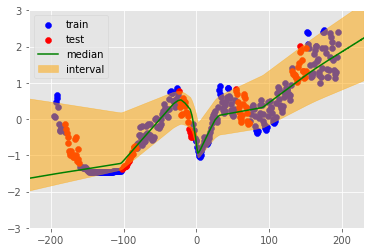

In [158]:
plot_train = np.concatenate((train_data, val_data))
plot_solar_regression(plot_train, test_data, line_X, line_y[:, 1], line_y[:, 0], line_y[:, 2])

In [159]:
test_X = torch.from_numpy(test_data[:, 0]).float().view(-1, 1)
test_preds, test_errors = ensemble_predict(solar_model_paths, model, test_X, device)
coverage = correct_coverage(test_data[:,1], test_preds[:, 0], test_preds[:, 2])
coverage # expected coverage: 0.9

Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


0.9

In [160]:
val_X = torch.from_numpy(val_data[:, 0]).float().view(-1, 1)
val_preds, val_errors = ensemble_predict(solar_model_paths, model, val_X, device)

q_score = conformal_calibration(val_data[:,1], val_preds[:, 0], val_preds[:, 2], 0.9)
q_score

Loading model from /mnt/e/models/iso_models/quantile/quantile_solar_*.pt


0.012542459368705778

In [161]:
coverage = correct_coverage(test_data[:,1], test_preds[:, 0]-q_score, test_preds[:, 2]+q_score)
coverage # expected coverage: 0.9

0.92

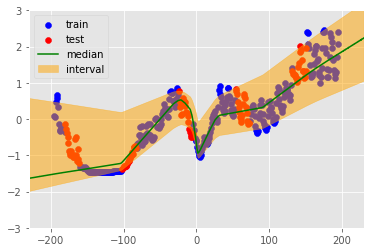

In [162]:
plot_solar_regression(plot_train, test_data, line_X, line_y[:, 1], line_y[:, 0]-q_score, line_y[:, 2]+q_score)

## UCI

In [165]:
def UCI_calibration_quantile(dataset, val_data, test_data, device):
    val_X = val_data[:, :-1]
    val_y = val_data[:, -1]
    test_X = test_data[:, :-1]
    test_y = test_data[:, -1]
    print(test_X.shape)
    
    quantiles = [0.05, 0.5, 0.95]

    model_paths = os.path.join(model_dir, "quantile", f"quantile_{dataset}_*.pt")
    model = QuantileMLP(input_dim=test_X.shape[1], output_dim=1, num_units=10, drop_prob=0.01, quantiles=quantiles)
    print(model)

    print("### Before calibration ###")
    test_preds, _ = ensemble_predict(model_paths, model, torch.from_numpy(test_X).float(), device)
    lower = test_preds[:, 0]
    upper = test_preds[:, 2]
    coverage = correct_coverage(test_y, lower, upper)
    print(f"Coverage: {coverage}")
    print()

    print("### Conformal calibrating ###")
    val_preds, _ = ensemble_predict(model_paths, model, torch.from_numpy(val_X).float(), device)
    q_score = conformal_calibration(val_y, val_preds[:, 0], val_preds[:, 2], 0.9)
    print(f"Q-score: {q_score}")
    coverage = correct_coverage(test_y, lower-q_score, upper+q_score)
    print(f"Coverage: {coverage}")

TODO: Biased validation set

### Housing

In [166]:
val_data = np.load("/mnt/e/data/house/val.npy")
test_data = np.load("/mnt/e/data/house/test.npy")
UCI_calibration_quantile("house", val_data, test_data, device)

(51, 12)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=30, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_house_*.pt
Coverage: 0.6862745098039216

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_house_*.pt
Q-score: -0.018795859581212784
Coverage: 0.6666666666666666


### Concrete

In [167]:
val_data = np.load("/mnt/e/data/concrete/val.npy")
test_data = np.load("/mnt/e/data/concrete/test.npy")
UCI_calibration_quantile("concrete", val_data, test_data, device)

(103, 7)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=30, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_*.pt
Coverage: 0.8446601941747572

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_concrete_*.pt
Q-score: -0.03409534978365068
Coverage: 0.7864077669902912


### Energy

In [168]:
val_data = np.load("/mnt/e/data/energy/val.npy")
test_data = np.load("/mnt/e/data/energy/test.npy")
UCI_calibration_quantile("energy", val_data, test_data, device)

(77, 8)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=30, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_*.pt
Coverage: 0.8831168831168831

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_energy_*.pt
Q-score: 0.03340973302062686
Coverage: 0.922077922077922


### Power

In [169]:
val_data = np.load("/mnt/e/data/power/val.npy")
test_data = np.load("/mnt/e/data/power/test.npy")
UCI_calibration_quantile("power", val_data, test_data, device)

(957, 3)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=30, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_power_*.pt
Coverage: 0.9070010449320794

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_power_*.pt
Q-score: -0.0013916217683411143
Coverage: 0.9070010449320794


### Red wine

In [170]:
val_data = np.load("/mnt/e/data/red_wine/val.npy")
test_data = np.load("/mnt/e/data/red_wine/test.npy")
UCI_calibration_quantile("red_wine", val_data, test_data, device)

(160, 10)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=30, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_*.pt
Coverage: 0.86875

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_red_wine_*.pt
Q-score: 0.01756100428869479
Coverage: 0.88125


### Yacht

In [171]:
val_data = np.load("/mnt/e/data/yacht/val.npy")
test_data = np.load("/mnt/e/data/yacht/test.npy")
UCI_calibration_quantile("yacht", val_data, test_data, device)

(31, 5)
QuantileMLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): Linear(in_features=30, out_features=3, bias=True)
  )
)
### Before calibration ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_yacht_*.pt
Coverage: 0.9032258064516129

### Conformal calibrating ###
Loading model from /mnt/e/models/iso_models/quantile/quantile_yacht_*.pt
Q-score: -0.04647511781394782
Coverage: 0.7741935483870968
